In [32]:
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import ecdf

In [33]:
def extract_bools(file: str):
    return "_".join([token for token in file.replace(".csv", "").split("_") if token in {"True", "False"}])

In [34]:
files = os.listdir("csvs")
# only basic reshuffling data with random search, no reshuffling and retrain of the model on combined train valid
reshuffling_files = [file for file in files if "reshuffling" in file and "hebo" not in file and "smac" not in file and "hebo_makarova" not in file and extract_bools(file) == "False_True"]
other_files = [file for file in files if "reshuffling" not in file]

In [35]:
files = reshuffling_files + other_files

In [36]:
res = []
for file in files:
    if not file.endswith(".csv"):
        continue
    tmp = pd.read_csv(os.path.join("csvs", file))
    tmp = tmp[(tmp["final_iteration"] == True) & (tmp["metric"] != "balanced_accuracy")]
    tmp.loc[:, "file"] = file
    res.append(tmp)

In [37]:
dat = pd.concat(res)

In [38]:
len(dat)

117578

In [39]:
dat["file"].value_counts()

file
tabzilla_binary_DecisionTree.csv                                       3760
tabzilla_binary_RandomForest.csv                                       3720
tabzilla_binary_LinearModel.csv                                        3640
tabzilla_binary_LightGBM.csv                                           3600
tabzilla_binary_KNN.csv                                                3440
                                                                       ... 
wdtb_categorical_classification_medium_SAINT.csv                          7
wdtb_categorical_classification_medium_HistGradientBoostingTree.csv       7
wdtb_categorical_classification_medium_Resnet.csv                         7
wdtb_categorical_classification_medium_GradientBoostingTree.csv           7
wdtb_categorical_classification_medium_RandomForest.csv                   7
Name: count, Length: 151, dtype: int64

In [40]:
overtuning_relative_ecdf = ecdf(dat[(dat["no_progress"] == False)]["overtuning_relative"])

In [41]:
overtuning_relative_ecdf.cdf.evaluate([0, 0.1, 0.5, 1.0])

array([0.60689674, 0.72116496, 0.84767023, 0.91480002])

In [42]:
studies = ["reshuffling", "wdtb", "tabzilla", "tabrepo", "lcbench", "fcnet", "pd1"]
studies_dict = {"reshuffling": "reshuffling", "wdtb": "WDTB", "tabzilla": "TabZilla", "tabrepo": "TabRepo", "lcbench": "LCBench", "fcnet": "FCNet", "pd1": "PD1"}

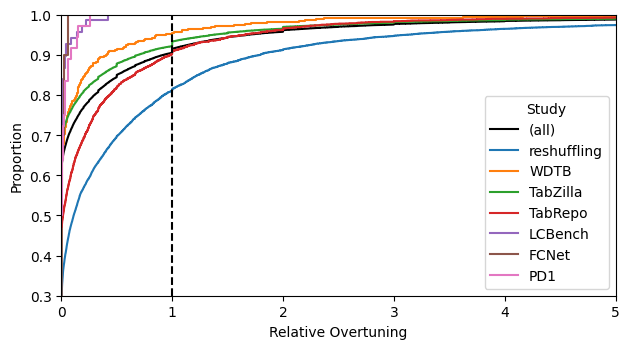

In [43]:
plt.figure(figsize=(6.4, 3.6))
plt.ecdf(
    data=dat[~dat["no_progress"]],
    x="overtuning_relative",
    label="(all)",
    color="black"
)

for study in studies:
    dat_tmp = dat[(~dat["no_progress"]) & (dat["file"].str.contains(study))]
    plt.ecdf(
        data=dat_tmp,
        x="overtuning_relative",
        label=studies_dict[study]
    )

plt.axvline(x=1.0, color="black", linestyle="--")
plt.xlabel("Relative Overtuning")
plt.ylabel("Proportion")
plt.xlim(0, 5)
plt.ylim(0.3, 1.0)
plt.legend(title="Study")
plt.tight_layout()

plt.savefig("/tmp/ecdf_all.pdf")

In [44]:
for study in studies:
    print(study)
    dat_tmp = dat[dat["file"].str.contains(study)]
    print(dat_tmp["no_progress"].mean())
    print(len(dat_tmp))
    plt.ecdf(
        data=dat_tmp[(dat_tmp["no_progress"] == False)],
        x="overtuning_relative"
    )
    plt.xlabel("Relative Overtuning")
    plt.ylabel("Proportion")
    plt.title(f"{study}")
    plt.xlim(left=0, right=5)
    plt.tight_layout()
    plt.axvline(x=1.0, color="black", linestyle="--")
    plt.savefig(f"/tmp/ecdf_{study}.pdf")
    plt.close()
    print("\n")

reshuffling
0.2845138888888889
14400


wdtb
0.06181015452538632
453


tabzilla
0.4106632361349343
97944


tabrepo
0.2987765614938828
4659


lcbench
0.02857142857142857
70


fcnet
0.375
16


pd1
0.0
36




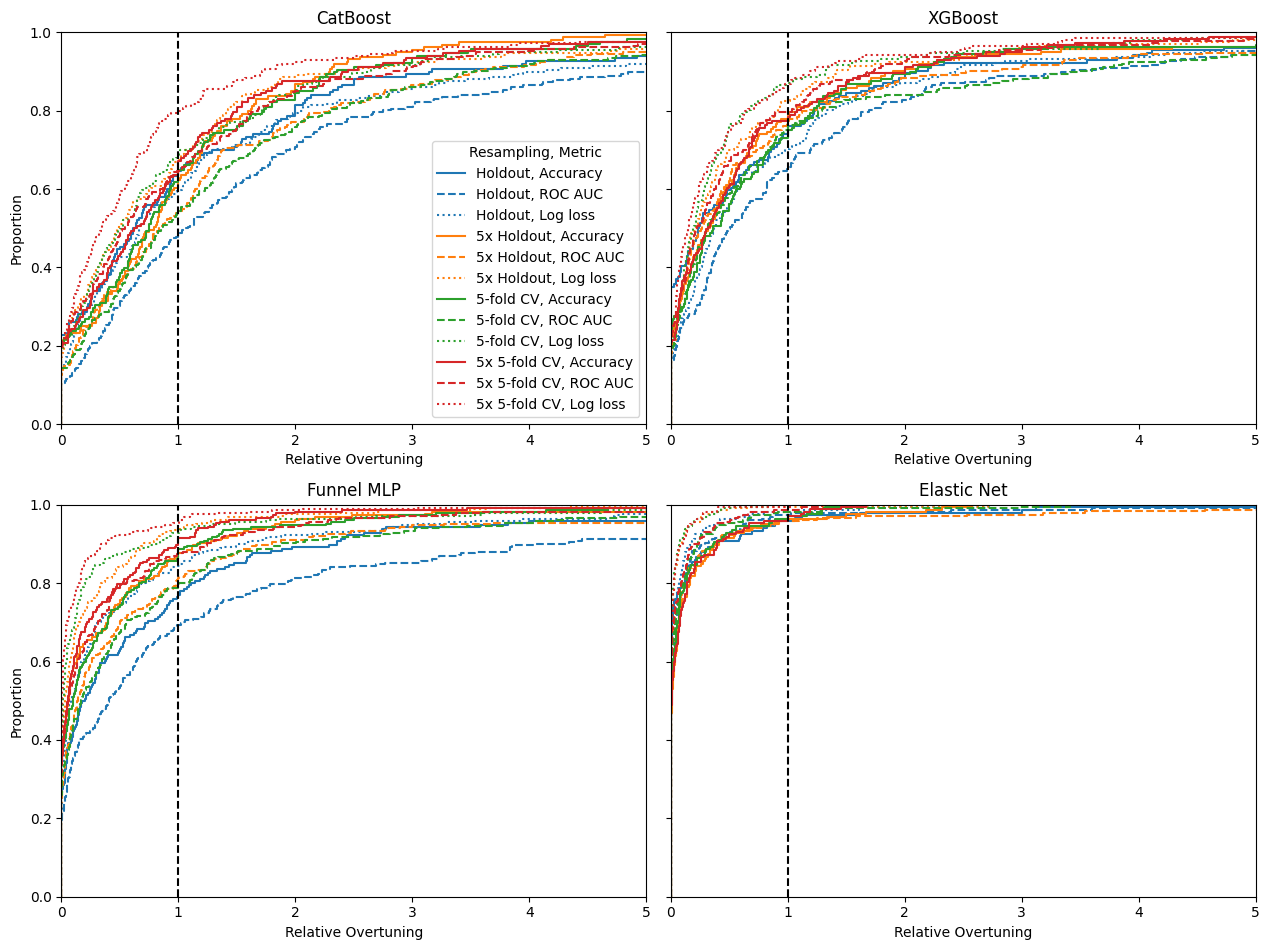

In [45]:
# reshuffling
dat_tmp = dat[dat["file"].str.contains("reshuffling")]

classifier_levels = {"catboost": "CatBoost", "xgboost": "XGBoost", "funnel_mlp": "Funnel MLP", "logreg": "Elastic Net"}
metric_levels = {"accuracy": "Accuracy", "auc": "ROC AUC", "logloss": "Log loss"}
resampling_levels = {"holdout": "Holdout", "repeatedholdout": "5x Holdout", "cv": "5-fold CV", "cv_repeated": "5x 5-fold CV"}
linestyles = {"accuracy": "-", "auc": "--", "logloss": ":"}
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colors = {"holdout": colors[0], "repeatedholdout": colors[1], "cv": colors[2], "cv_repeated": colors[3]}

metrics_levels = {"accuracy": "Accuracy", "auc": "ROC AUC", "logloss": "Log loss"}
fig, axes = plt.subplots(2, 2, figsize=(12.8, 9.6), sharey=True)
axes = axes.flatten()

for idx, classifier in enumerate(classifier_levels.keys()):
    ax = axes[idx]
    for resampling in resampling_levels.keys():
        for metric in metric_levels.keys():
            subset = dat_tmp[
                (dat_tmp["no_progress"] == False) &
                (dat_tmp["metric"] == metric) &
                (dat_tmp["resampling"] == resampling) &
                (dat_tmp["classifier"] == classifier)
            ]
            ax.ecdf(
                data=subset,
                x="overtuning_relative",
                label=f"{resampling_levels[resampling]}, {metrics_levels[metric]}",
                color=colors[resampling],
                linestyle=linestyles[metric]
            )
    ax.set_title(classifier_levels[classifier])
    ax.set_xlabel("Relative Overtuning")
    ax.axvline(x=1.0, color="black", linestyle="--")
    if idx in [0, 2]:
        if idx == 0:
            ax.legend(title="Resampling, Metric")
        ax.set_ylabel("Proportion")
    ax.set_xlim(left=0, right=5)

fig.tight_layout()
plt.savefig("/tmp/ecdf_reshuffling_detailed.pdf")

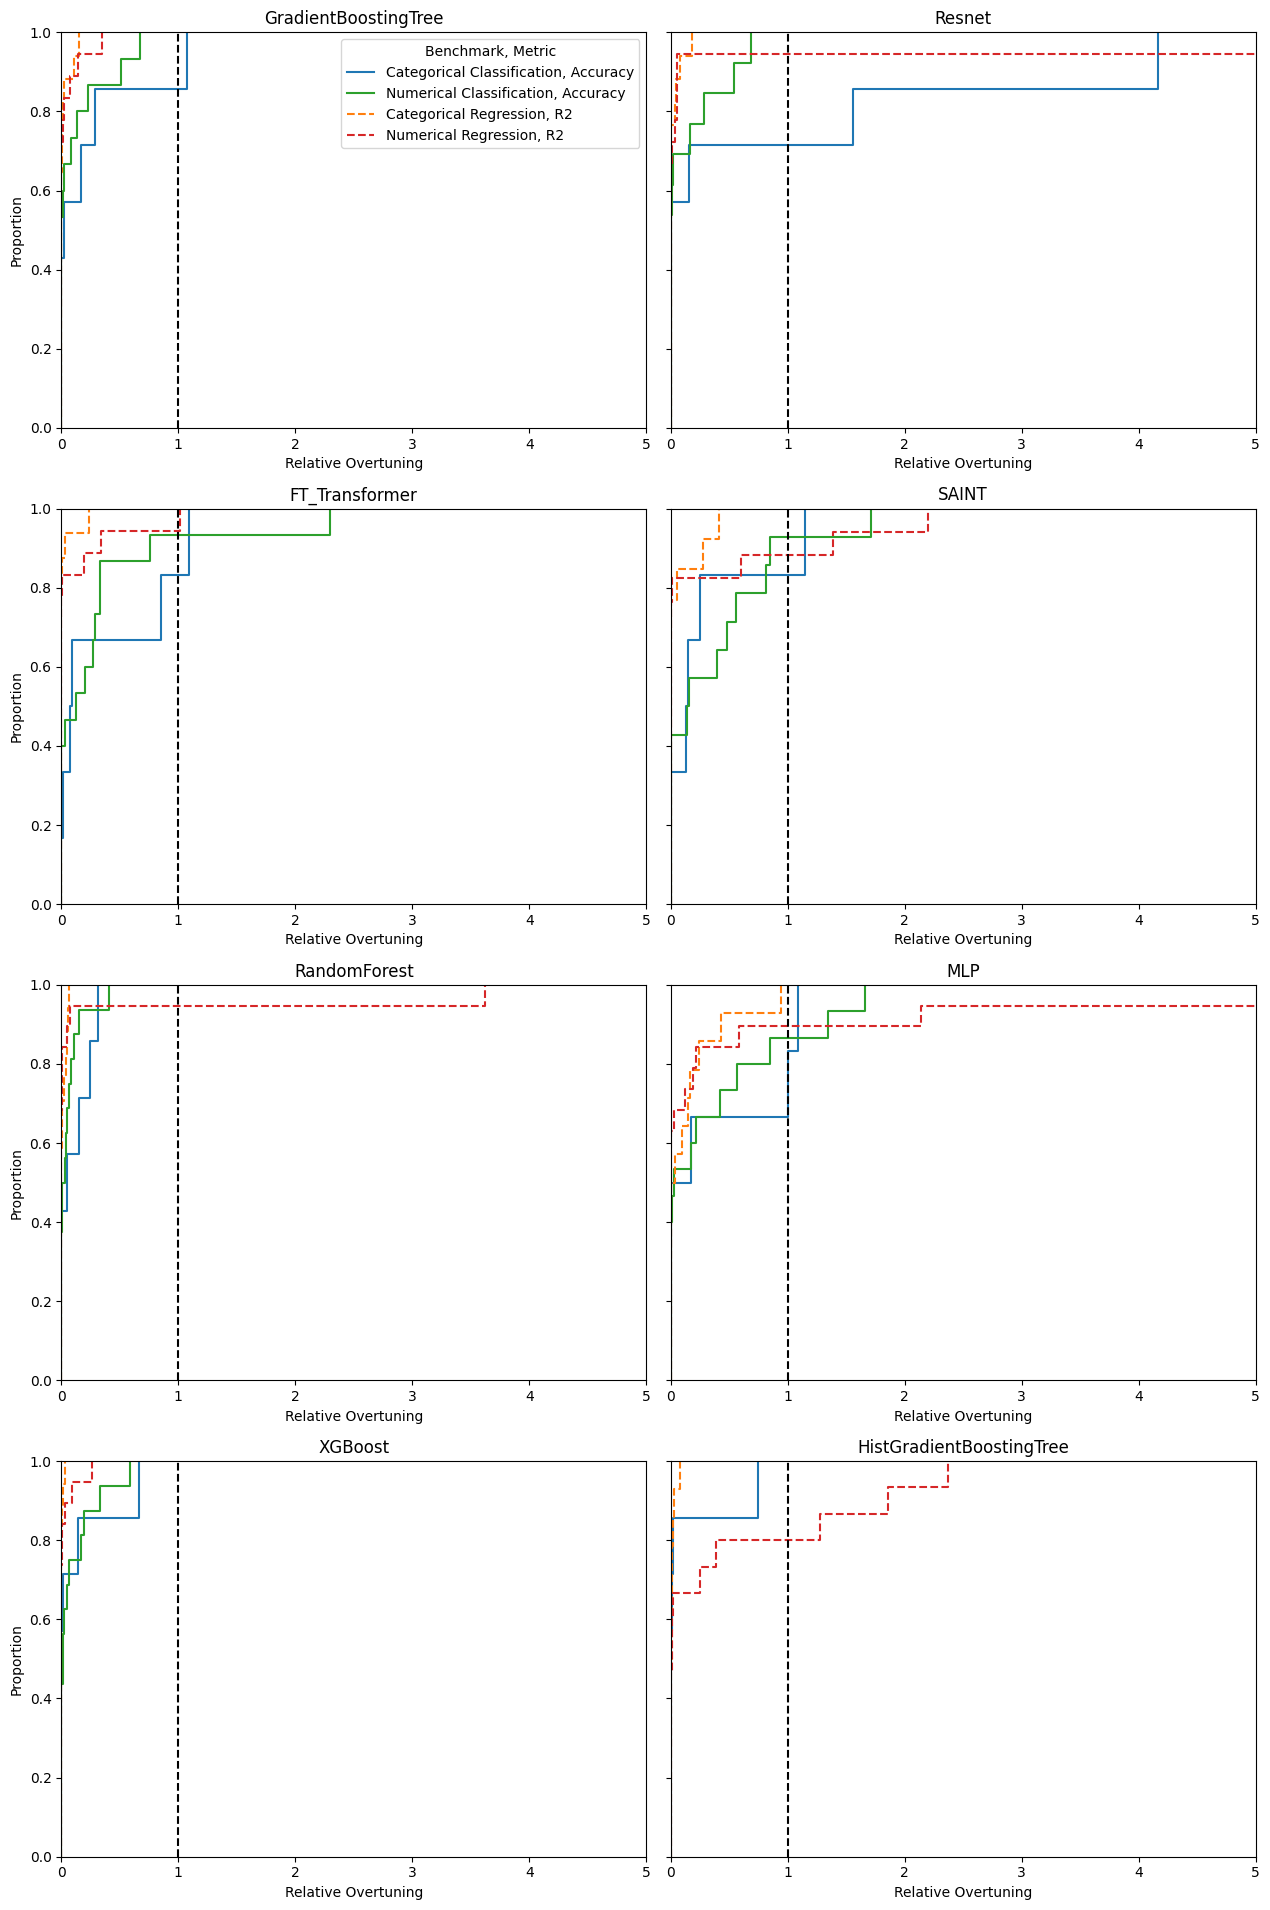

In [46]:
# wtdb
dat_tmp = dat[dat["file"].str.contains("wdtb")]

model_levels = {"GradientBoostingTree": "GradientBoostingTree", "Resnet": "Resnet", "FT_Transformer": "FT_Transformer", "SAINT": "SAINT",
                "RandomForest": "RandomForest", "MLP": "MLP", "XGBoost": "XGBoost", "HistGradientBoostingTree": "HistGradientBoostingTree"}
benchmark_levels = {"categorical_classification_medium": "Categorical Classification", "numerical_classification_medium": "Numerical Classification",
                    "categorical_regression_medium": "Categorical Regression", "numerical_regression_medium": "Numerical Regression"}
linestyles = {"accuracy": "-", "r2": "--"}
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colors = {"categorical_classification_medium": colors[0], "categorical_regression_medium": colors[1], "numerical_classification_medium": colors[2], "numerical_regression_medium": colors[3]}

metrics_levels = {"accuracy": "Accuracy", "r2": "R2"}
fig, axes = plt.subplots(4, 2, figsize=(12.8, 19.2), sharey=True)
axes = axes.flatten()

for idx, model in enumerate(model_levels.keys()):
    ax = axes[idx]
    for benchmark in benchmark_levels.keys():
        if benchmark in ["categorical_classification_medium", "numerical_classification_medium"]:
            metric = "accuracy"
        else:
            metric = "r2"
        subset = dat_tmp[
            (dat_tmp["no_progress"] == False) &
            (dat_tmp["metric"] == metric) &
            (dat_tmp["benchmark"] == benchmark) &
            (dat_tmp["model"] == model)
        ]
        if len(subset) == 0:
            continue
        ax.ecdf(
            data=subset,
            x="overtuning_relative",
            label=f"{benchmark_levels[benchmark]}, {metrics_levels[metric]}",
            color=colors[benchmark],
            linestyle=linestyles[metric]
        )
    ax.set_title(model_levels[model])
    ax.set_xlabel("Relative Overtuning")
    ax.axvline(x=1.0, color="black", linestyle="--")
    if idx in [0, 2, 4, 6]:
        if idx == 0:
            ax.legend(title="Benchmark, Metric")
        ax.set_ylabel("Proportion")
    ax.set_xlim(left=0, right=5)

fig.tight_layout()
plt.savefig("/tmp/ecdf_wdtb_detailed.pdf")

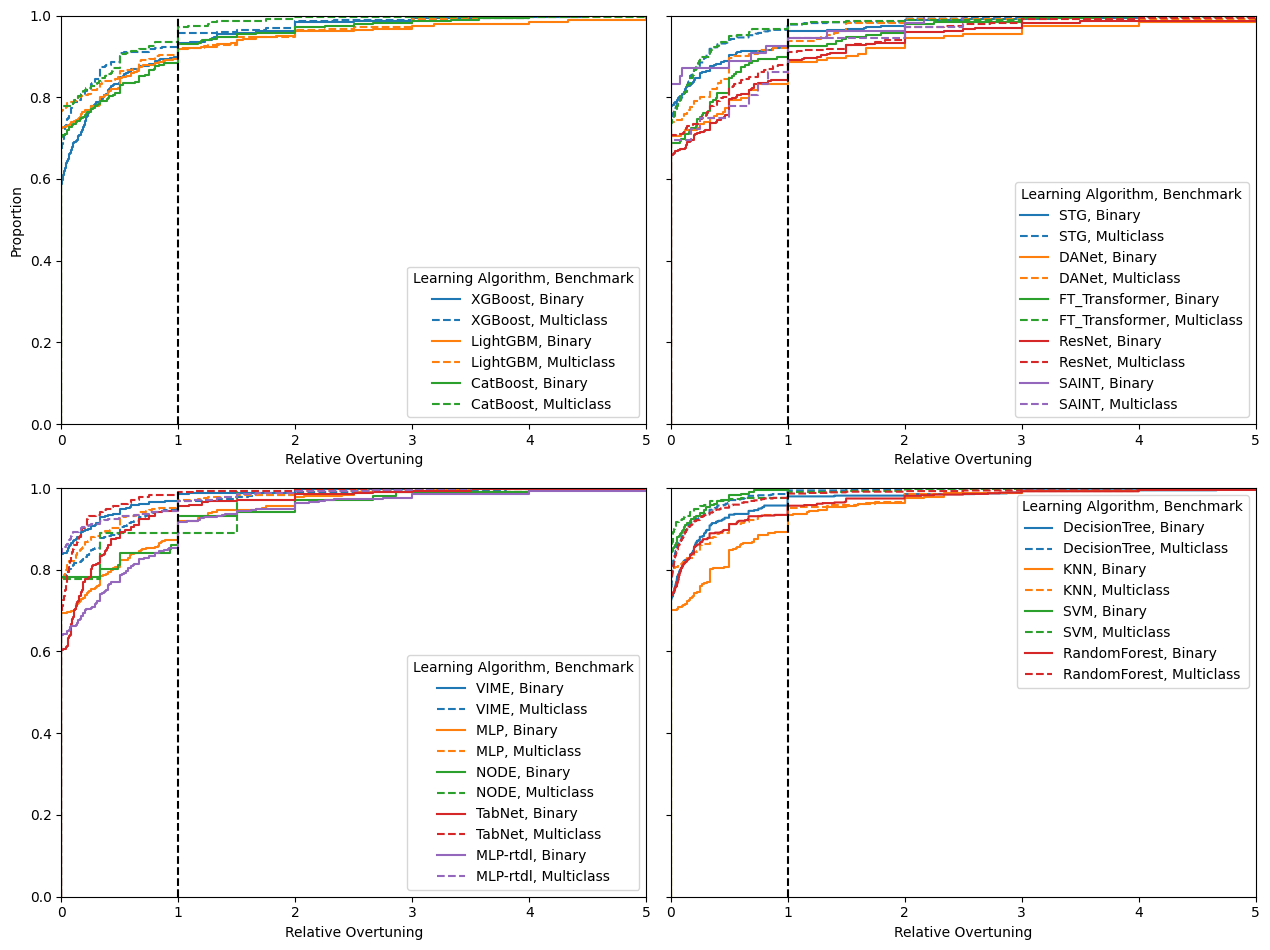

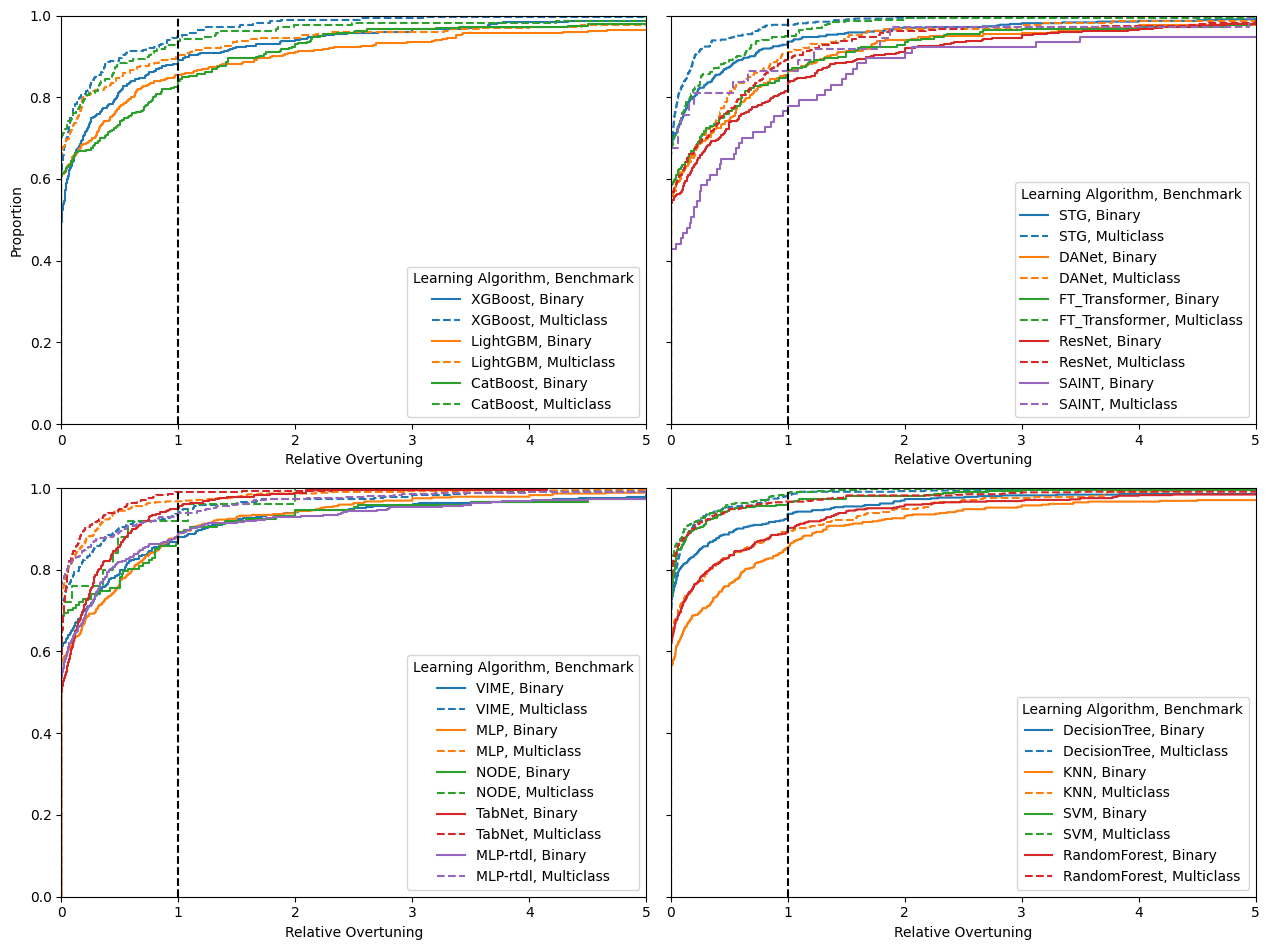

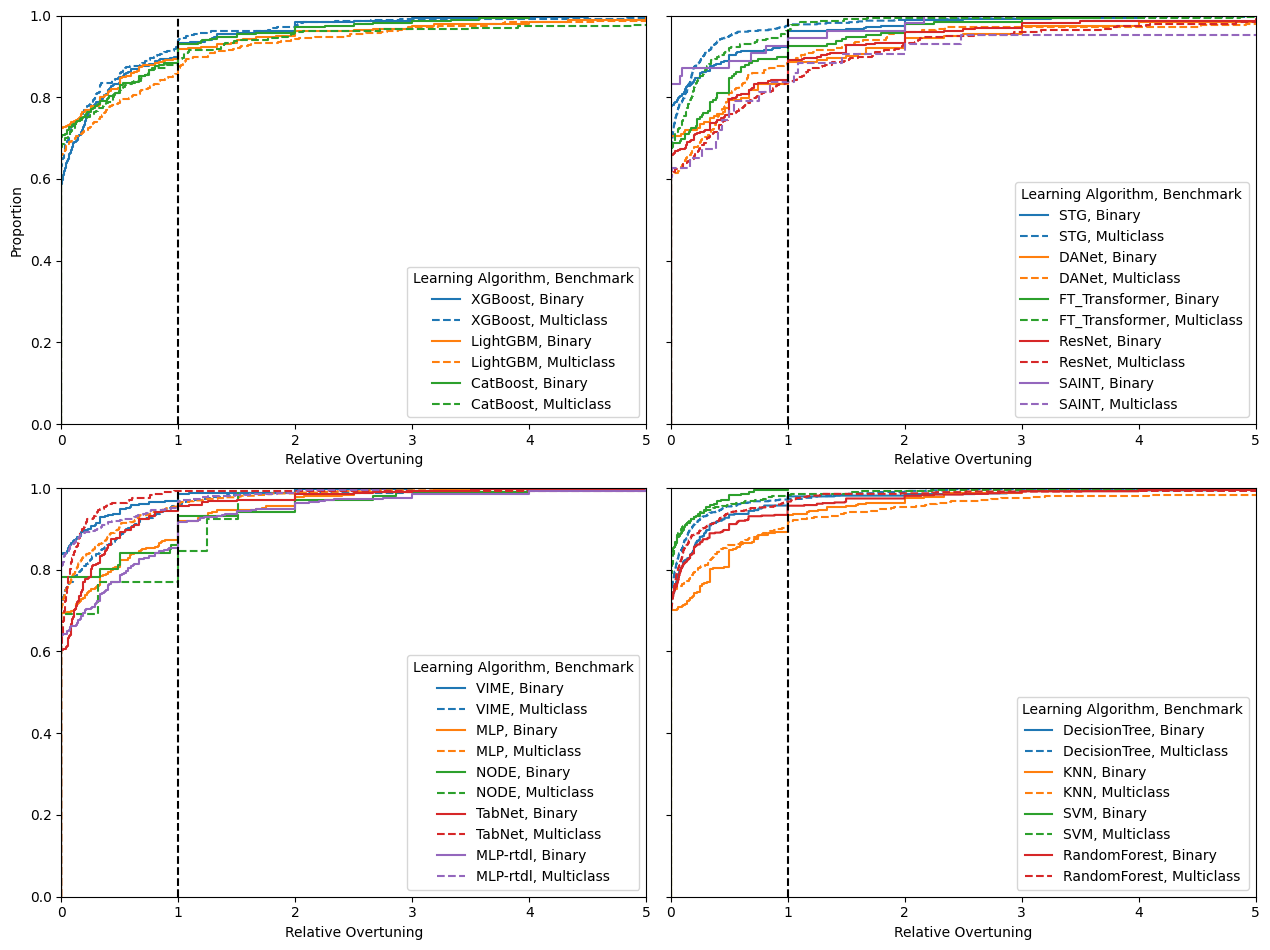

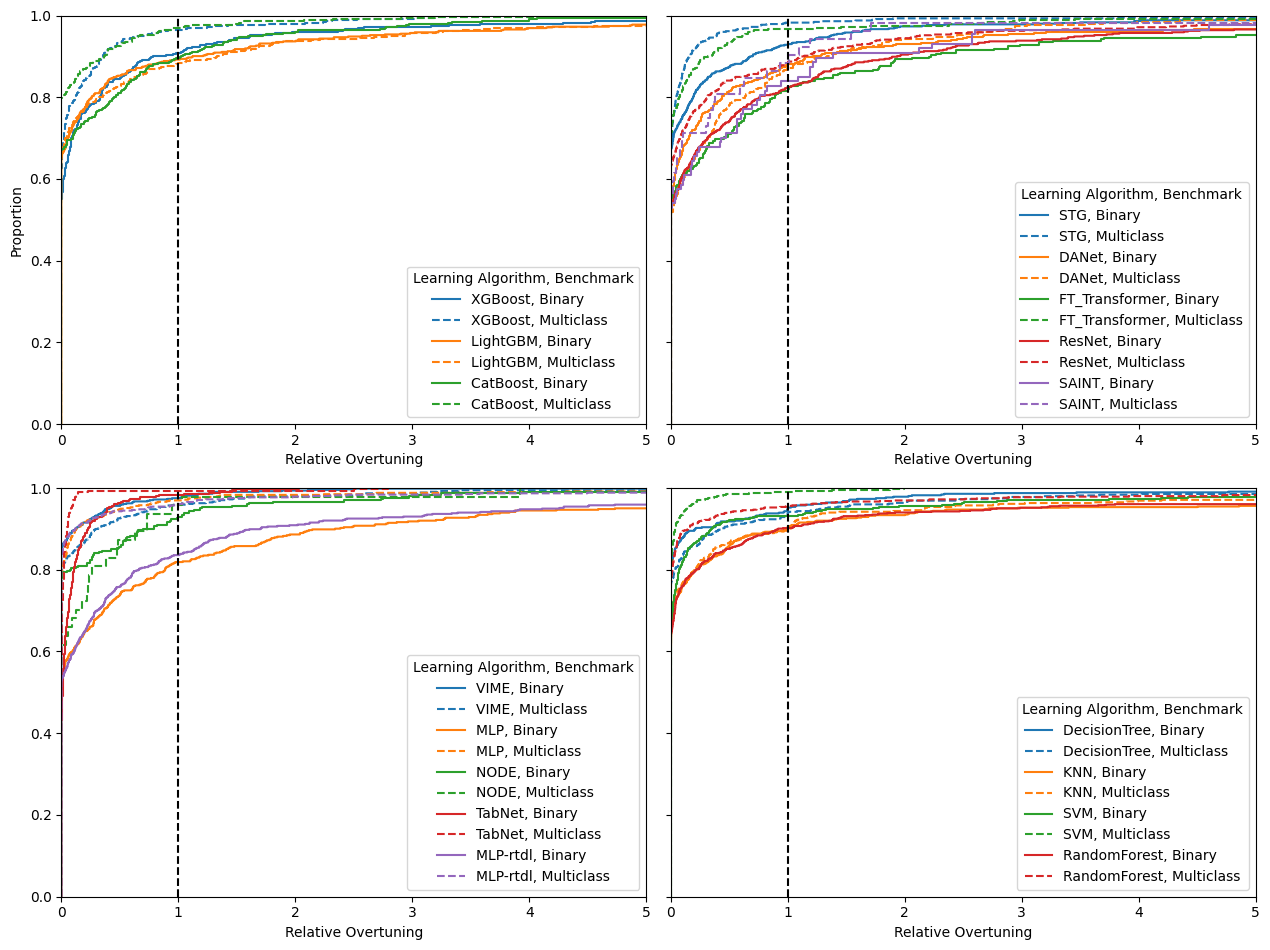

In [47]:
# tabzilla
dat_tmp = dat[dat["file"].str.contains("tabzilla")]

# Figure 3 of McElfresh et al. (2024)
# excluded linear model and other learning algorithms with too few random search iterations
metric_levels = {"accuracy": "Accuracy", "auc": "ROC AUC", "f1": "F1", "logloss": "Log loss"}
model_groups = {"Tree": ["XGBoost", "LightGBM", "CatBoost"],
                "NN_good": ["STG", "DANet", "rtdl_FTTransformer", "rtdl_ResNet", "SAINT"],
                "NN_bad": ["VIME", "MLP", "NODE", "TabNet", "rtdl_MLP"],
                "baseline": ["DecisionTree", "KNN", "SVM", "RandomForest"]}   
model_levels = {"XGBoost": "XGBoost", "CatBoost": "CatBoost", "LightGBM": "LightGBM",
                "VIME": "VIME", "MLP": "MLP", "NODE": "NODE", "TabNet": "TabNet", "rtdl_MLP": "MLP-rtdl", "STG": "STG",
                "DANet": "DANet", "SAINT": "SAINT", "rtdl_ResNet": "ResNet", "rtdl_FTTransformer": "FT_Transformer",
                "DecisionTree": "DecisionTree", "KNN": "KNN", "SVM": "SVM", "RandomForest": "RandomForest"}
benchmark_levels = {"binary": "Binary", "multiclass": "Multiclass"}
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
linestyles = {"binary": "-", "multiclass": "--"}

for metric in metric_levels.keys():
    fig, axes = plt.subplots(2, 2, figsize=(12.8, 9.6), sharey=True)
    axes = axes.flatten()
    for idx, model_group in enumerate(model_groups.keys()):
        ax = axes[idx]
        models_in_group = model_groups[model_group]
        group_colors = colors[:len(models_in_group)]
        colors_model_group = {model: group_colors[i] for i, model in enumerate(models_in_group)}
        for model in models_in_group:
            for benchmark in benchmark_levels.keys():
                subset = dat_tmp[
                    (dat_tmp["no_progress"] == False) &
                    (dat_tmp["benchmark"] == benchmark) &
                    (dat_tmp["model"] == model) &
                    (dat_tmp["metric"] == metric)
                ]
                ax.ecdf(
                    data=subset,
                    x="overtuning_relative",
                    label=f"{model_levels[model]}, {benchmark_levels[benchmark]}",
                    color=colors_model_group[model],
                    linestyle=linestyles[benchmark]
                )
        ax.set_xlabel("Relative Overtuning")
        ax.axvline(x=1.0, color="black", linestyle="--")
        if idx == 0:
            ax.set_ylabel("Proportion")
        ax.set_xlim(left=0, right=5)
        ax.legend(title="Learning Algorithm, Benchmark")
    fig.tight_layout()
    plt.savefig(f"/tmp/ecdf_tabzilla_detailed_{metric}.pdf")

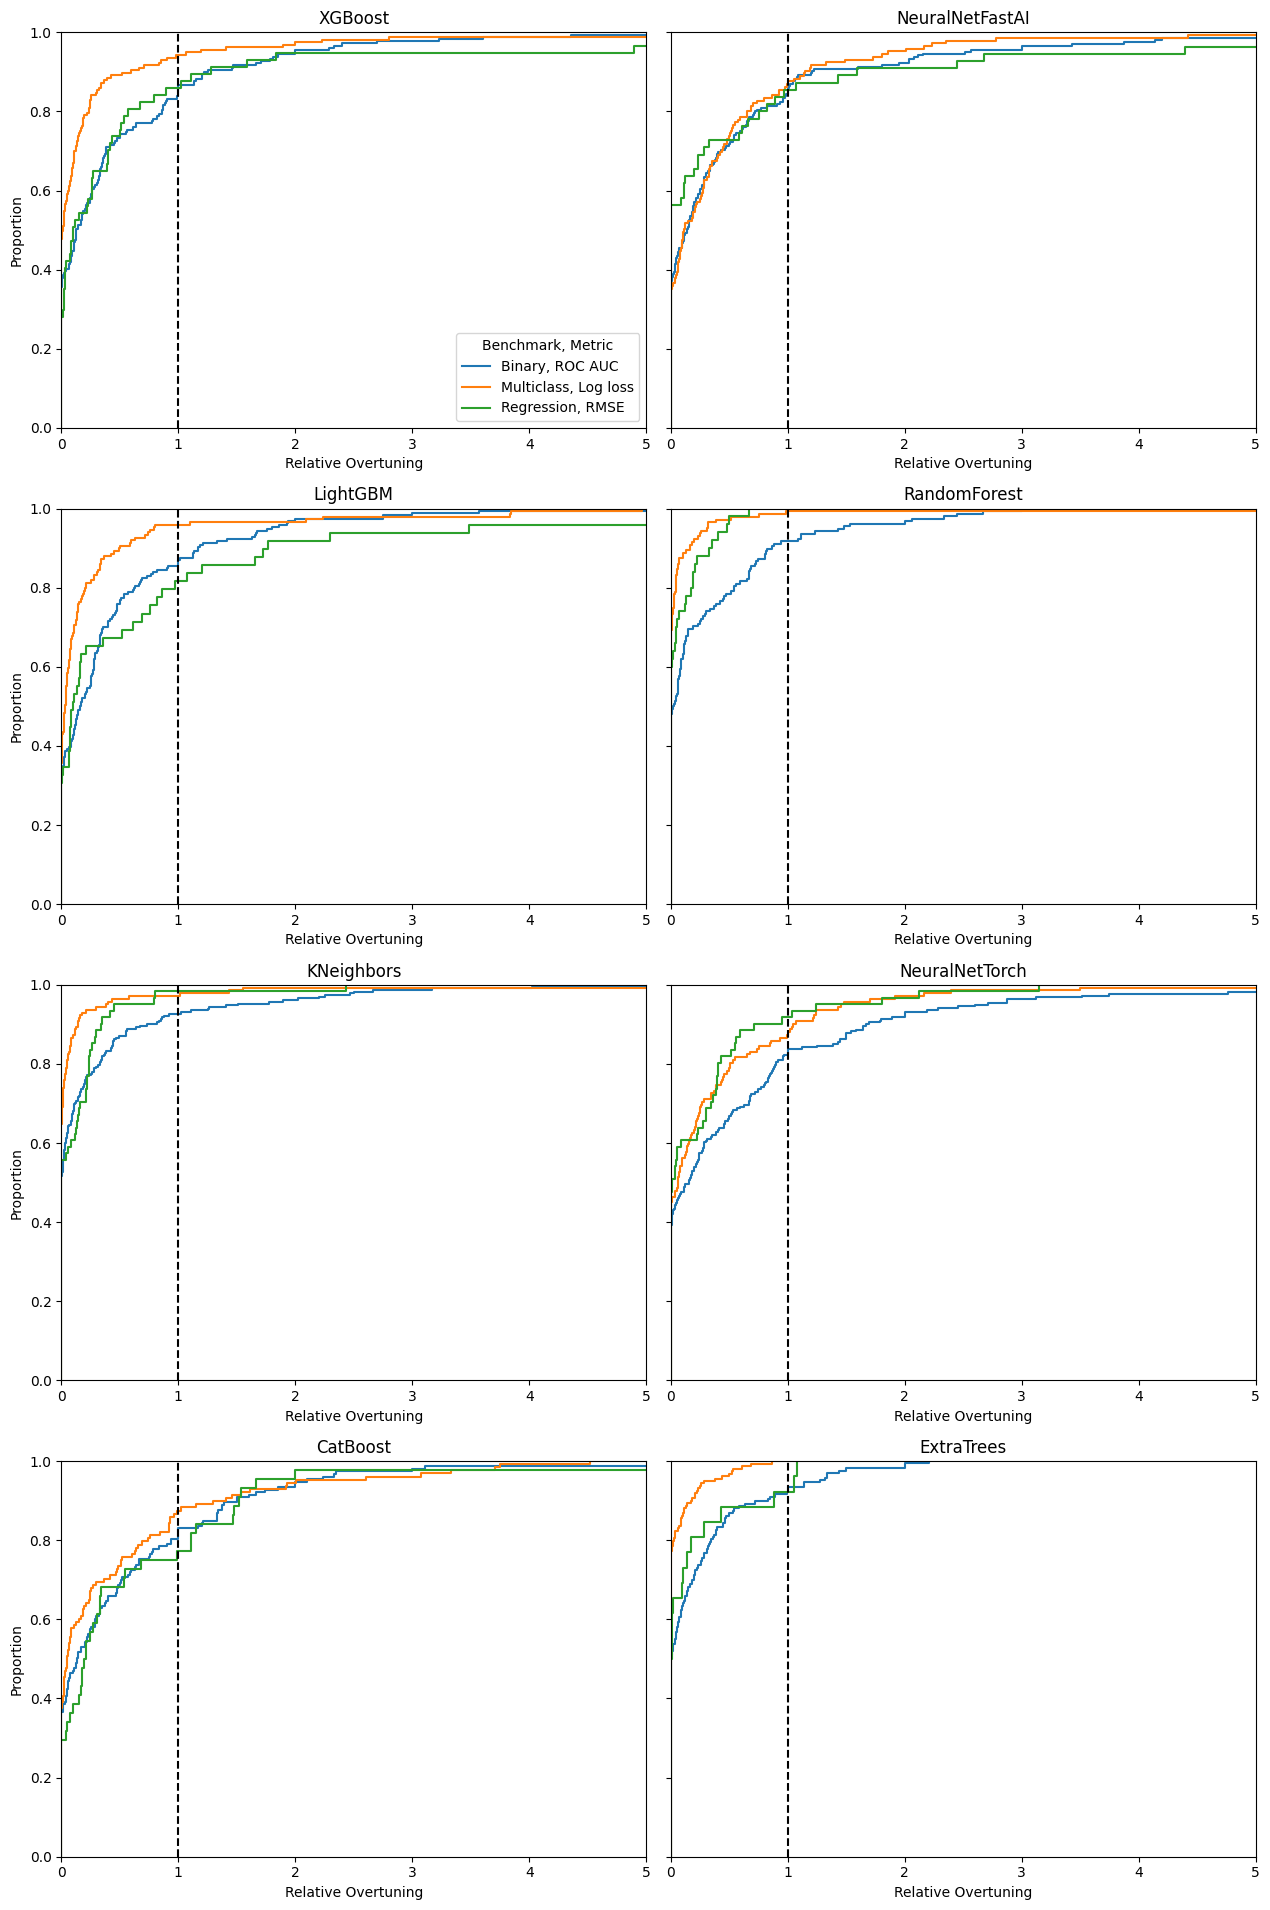

In [48]:
# tabrepo
dat_tmp = dat[dat["file"].str.contains("tabrepo")]

# excluded Linear Model
model_levels = {"XGBoost": "XGBoost", "NeuralNetFastAI": "NeuralNetFastAI", "LightGBM": "LightGBM", "RandomForest": "RandomForest",
                "KNeighbors": "KNeighbors", "NeuralNetTorch": "NeuralNetTorch", "CatBoost": "CatBoost", "ExtraTrees": "ExtraTrees"}
benchmark_levels = {"binary": "Binary", "multiclass": "Multiclass", "regression": "Regression"}
#linestyles = {"roc_auc": "-", "log_loss": "--", "rmse": ":"}
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colors = {"binary": colors[0], "multiclass": colors[1], "regression": colors[2]}

metrics_levels = {"roc_auc": "ROC AUC", "log_loss": "Log loss", "rmse": "RMSE"}
fig, axes = plt.subplots(4, 2, figsize=(12.8, 19.2), sharey=True)
axes = axes.flatten()

for idx, model in enumerate(model_levels.keys()):
    ax = axes[idx]
    for benchmark in benchmark_levels.keys():
        if benchmark == "binary":
            metric = "roc_auc"
        elif benchmark == "multiclass":
            metric = "log_loss"
        else:
            metric = "rmse"
        subset = dat_tmp[
            (dat_tmp["no_progress"] == False) &
            (dat_tmp["metric"] == metric) &
            (dat_tmp["benchmark"] == benchmark) &
            (dat_tmp["model"] == model)
        ]
        ax.ecdf(
            data=subset,
            x="overtuning_relative",
            label=f"{benchmark_levels[benchmark]}, {metrics_levels[metric]}",
            color=colors[benchmark],
            #linestyle=linestyles[metric]
        )
    ax.set_title(model_levels[model])
    ax.set_xlabel("Relative Overtuning")
    ax.axvline(x=1.0, color="black", linestyle="--")
    if idx in [0, 2, 4, 6]:
        if idx == 0:
            ax.legend(title="Benchmark, Metric")
        ax.set_ylabel("Proportion")
    ax.set_xlim(left=0, right=5)

fig.tight_layout()
plt.savefig("/tmp/ecdf_tabrepo_detailed.pdf")

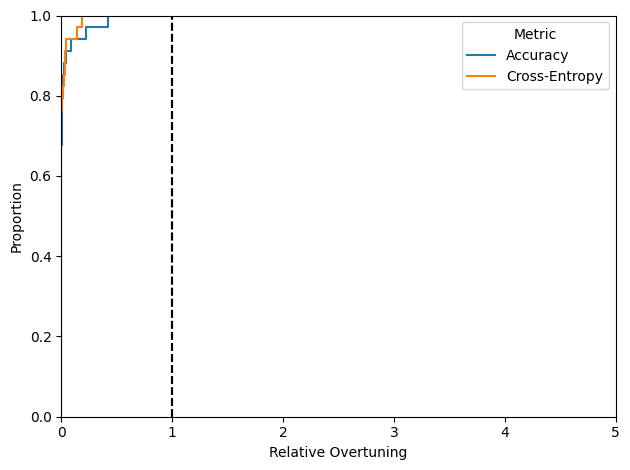

In [49]:
# LCBench
dat_tmp = dat[dat["file"].str.contains("lcbench")]

metrics_levels = {"accuracy": "Accuracy", "cross_entropy": "Cross-Entropy"}
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colors = {"accuracy": colors[0], "cross_entropy": colors[1]}

for metric in metrics_levels.keys():
    subset = dat_tmp[
        (dat_tmp["no_progress"] == False) &
        (dat_tmp["metric"] == metric)
    ]
    plt.ecdf(
        data=subset,
        x="overtuning_relative",
        label=f"{metrics_levels[metric]}",
    )
    plt.xlabel("Relative Overtuning")
    plt.ylabel("Proportion")
    plt.legend(title="Metric")
    plt.xlim(left=0, right=5)
    plt.tight_layout()
    plt.axvline(x=1.0, color="black", linestyle="--")
fig.tight_layout()
plt.savefig("/tmp/ecdf_lcbench_detailed.pdf")

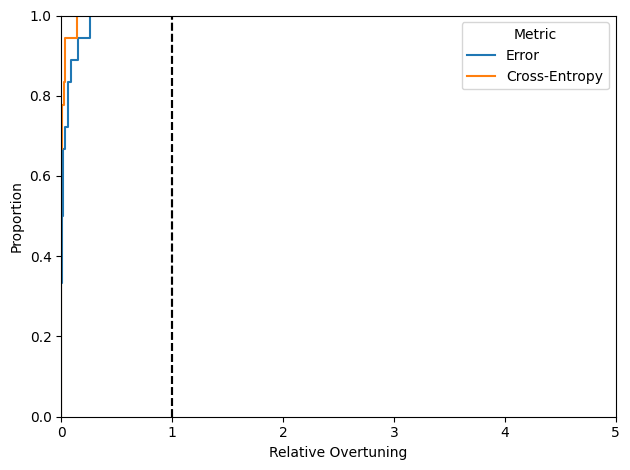

In [50]:
# PD1
dat_tmp = dat[dat["file"].str.contains("pd1")]

metrics_levels = {"error": "Error", "ce_loss": "Cross-Entropy"}
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colors = {"error": colors[0], "ce_loss": colors[1]}

for metric in metrics_levels.keys():
    subset = dat_tmp[
        (dat_tmp["no_progress"] == False) &
        (dat_tmp["metric"] == metric)
    ]
    plt.ecdf(
        data=subset,
        x="overtuning_relative",
        label=f"{metrics_levels[metric]}",
    )
    plt.xlabel("Relative Overtuning")
    plt.ylabel("Proportion")
    plt.legend(title="Metric")
    plt.xlim(left=0, right=5)
    plt.tight_layout()
    plt.axvline(x=1.0, color="black", linestyle="--")
fig.tight_layout()
plt.savefig("/tmp/ecdf_pd1_detailed.pdf")

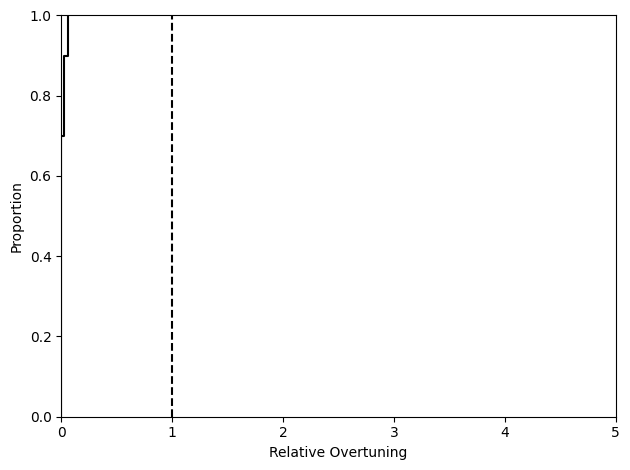

In [51]:
# FCNet
dat_tmp = dat[dat["file"].str.contains("fcnet")]

plt.ecdf(
    data=dat_tmp[dat_tmp["no_progress"] == False],
    x="overtuning_relative",
    color="black"
)
plt.xlabel("Relative Overtuning")
plt.ylabel("Proportion")
plt.xlim(left=0, right=5)
plt.tight_layout()
plt.axvline(x=1.0, color="black", linestyle="--")
fig.tight_layout()
plt.savefig("/tmp/ecdf_fcnet_detailed.pdf")